In [33]:
import pandas as pd

# Carregar o dataset
df_games = pd.read_csv('./dataset/data/steam_games.csv')

# Mapeamento das avaliações para os valores numéricos
review_map = {
    'Muy positivas': 5,
    'Extremadamente positivas': 5,
    'Mayormente positivas': 4,
    'Positiva': 4,
    'Positivas': 4,
    'Variadas': None,  # Não atribuir valor para "Variadas"
    'Negativa': 3,
    'Negativas': 3,
    'Mayormente negativas': 2,
    'Muy negativas': 1,
    'Extremadamente negativas': 0,
    '2 reseña(s) de usuario(s)': None,
    '3 reseña(s) de usuario(s)': None,
    '4 reseña(s) de usuario(s)': None,
    '5 reseña(s) de usuario(s)': None,
    '6 reseña(s) de usuario(s)': None,
    '7 reseña(s) de usuario(s)': None,
    '8 reseña(s) de usuario(s)': None,
    '9 reseña(s) de usuario(s)': None,
    '1 reseña(s) de usuario(s)': None
}

# Substituir as avaliações textuais pelas numéricas apenas nas colunas relevantes
for column in df_games.columns:
    if df_games[column].dtype == 'object':  # Verificando se a coluna é do tipo string (textual)
        # Substituir os valores de acordo com o mapeamento e manter valores originais, caso não estejam no review_map
        df_games[column] = df_games[column].apply(lambda x: review_map[x] if x in review_map else x)

# Exibir o novo dataset para verificar as mudanças
print(df_games.head())

# Salvar o novo dataset com as avaliações numéricas
df_games.to_csv('./dataset/data/steam_games_updated.csv', index=False)


   Unnamed: 0  is_dlc                                            img_src  \
0           0   False  https://cdn.akamai.steamstatic.com/steam/apps/...   
1           1   False  https://cdn.akamai.steamstatic.com/steam/apps/...   
2           2   False  https://cdn.akamai.steamstatic.com/steam/apps/...   
3           3   False  https://cdn.akamai.steamstatic.com/steam/apps/...   
4           4    True  https://cdn.akamai.steamstatic.com/steam/apps/...   

                                   short_description  recent_reviews  \
0  Las estaciones dinámicas lo cambian todo en el...             5.0   
1  Únete a más de 20 millones de jugadores en el ...             4.0   
2  Ready or Not es un intenso juego de disparos t...             5.0   
3  Descubre el épico final de la prolongada conti...             5.0   
4                                                NaN             2.0   

  recent_reviews_count  all_reviews all_reviews_count  reviews_anomally  \
0               -3,113          5.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10792 entries, 0 to 10791
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               10792 non-null  int64  
 1   is_dlc                   10792 non-null  bool   
 2   img_src                  10792 non-null  object 
 3   short_description        10792 non-null  object 
 4   recent_reviews           10792 non-null  float64
 5   recent_reviews_count     10792 non-null  float64
 6   all_reviews              10792 non-null  float64
 7   all_reviews_count        10792 non-null  float64
 8   reviews_anomally         10792 non-null  bool   
 9   release_date             10792 non-null  object 
 10  developer                10792 non-null  object 
 11  developer_url            10792 non-null  object 
 12  publisher                10792 non-null  object 
 13  publisher_url            10792 non-null  object 
 14  tags                  

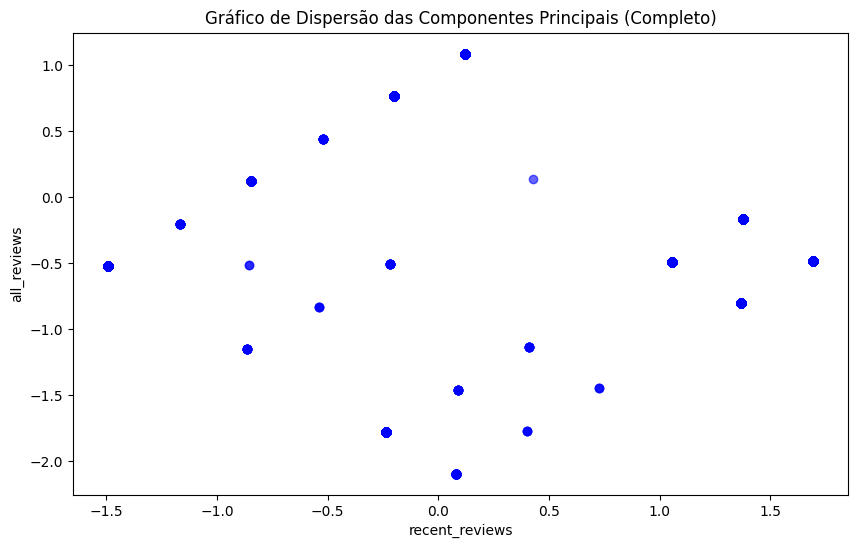

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

# Carregar o dataset
df_games = pd.read_csv('./dataset/data/steam_games_updated.csv')


# Substituir vírgulas e converter colunas para tipo float
for column in ['recent_reviews', 'recent_reviews_count', 'all_reviews', 'all_reviews_count', 'genre']:
    if column in df_games.columns:
        df_games[column] = (
            df_games[column]
            .replace({',': '', '-': ''}, regex=True)  # Remover vírgulas e hifens
        )
        # Converter para float usando pd.to_numeric com o argumento correto
        df_games[column] = pd.to_numeric(df_games[column], errors='coerce')

# Preencher valores ausentes com 0 ou outro valor apropriado
df_games = df_games.fillna(0)

# Confirmar que os dados estão limpos
print(df_games.info())

# Padronizar os dados (importantíssimo para PCA)
scaler = StandardScaler()
df_games_scaled = scaler.fit_transform(
    df_games[['recent_reviews',  'all_reviews']]  # Certifique-se de que as colunas estão disponíveis e numericamente padronizadas
)

# Aplicar PCA
pca = PCA(n_components=2)  # Reduzir para 2 componentes principais
df_pca = pca.fit_transform(df_games_scaled)

# Adicionar as componentes principais ao dataset
df_games['PCA_1'] = df_pca[:, 0]
df_games['PCA_2'] = df_pca[:, 1]

# Visualizar a variância explicada pelas componentes principais
print(f"recent_reviews: {pca.explained_variance_ratio_[0]:.4f}")
print(f"all_reviews: {pca.explained_variance_ratio_[1]:.4f}")

# Gráfico de dispersão das componentes principais para o dataset completo
plt.figure(figsize=(10, 6))
plt.scatter(df_games['PCA_1'], df_games['PCA_2'], color='blue', alpha=0.6)
plt.title('Gráfico de Dispersão das Componentes Principais (Completo)')
plt.xlabel('recent_reviews')
plt.ylabel('all_reviews')
plt.show()



              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1689
           1       1.00      1.00      1.00       470

    accuracy                           1.00      2159
   macro avg       1.00      1.00      1.00      2159
weighted avg       1.00      1.00      1.00      2159

[[1689    0]
 [   0  470]]


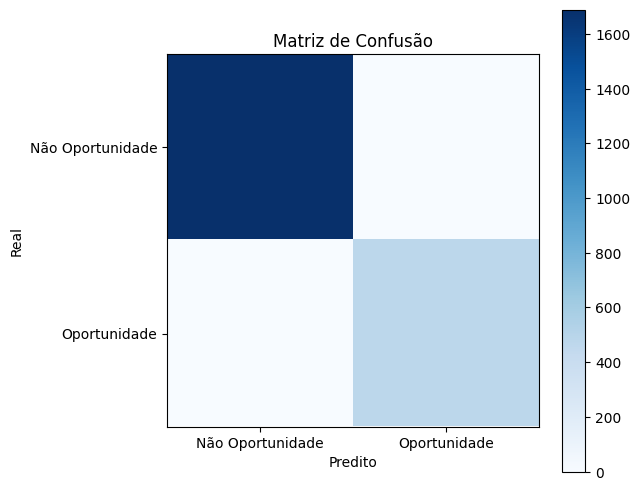

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Criar variável de target
df_games['is_market_opportunity'] = (
    (df_games['recent_reviews'] > df_games['recent_reviews'].median()) &  # Alta qualidade
    (df_games['all_reviews_count'] < 500)  # Baixa popularidade
).astype(int)

# Selecionar as features (características) e a variável target
X = df_games[['recent_reviews', 'all_reviews_count', 'recent_reviews_count', 'all_reviews']]  # Características
y = df_games['is_market_opportunity']  # Target (se é uma oportunidade de mercado)

# Dividir em dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o modelo (Random Forest)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Avaliar o modelo
y_pred = model.predict(X_test)

# Exibir relatório de classificação
print(classification_report(y_test, y_pred))

# Exibir matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Plotar matriz de confusão
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.colorbar()
plt.xlabel('Predito')
plt.ylabel('Real')
plt.xticks([0, 1], ['Não Oportunidade', 'Oportunidade'])
plt.yticks([0, 1], ['Não Oportunidade', 'Oportunidade'])
plt.show()

In [63]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Identificar o índice do melhor modelo no conjunto de treino
best_model_index = grid_search.best_index_

# Obter o respectivo jogo e gênero
best_game = X_train.iloc[best_model_index]
game_name = df_games.loc[best_game.name, 'name']
game_genre = df_games.loc[df_games['name'] == game_name, 'genre'].values[0]

print(f"Jogo correspondente: {game_name}")
print(f"Gênero correspondente: {game_genre}")

# Exibir melhores parâmetros
print("Melhores parâmetros encontrados:", grid_search.best_params_)

# Melhor modelo
best_model = grid_search.best_estimator_

# Avaliar o modelo otimizado
y_pred_optimized = best_model.predict(X_test)
print(classification_report(y_test, y_pred_optimized))


Melhores parâmetros encontrados: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Jogo correspondente: KAMUI
Gênero correspondente: 0.0
Melhores parâmetros encontrados: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1689
           1       1.00      1.00      1.00       470

    accuracy                           1.00      2159
   macro avg       1.00      1.00      1.00      2159
weighted avg       1.00      1.00      1.00      2159



Acurácia: 1.0000
Precisão: 1.0000
Recall: 1.0000
F1-Score: 1.0000
Matriz de Confusão:
[[1689    0]
 [   0  470]]


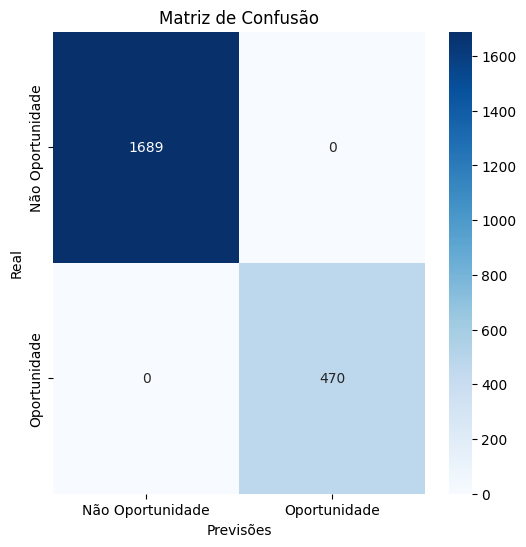

AUC: 1.0000


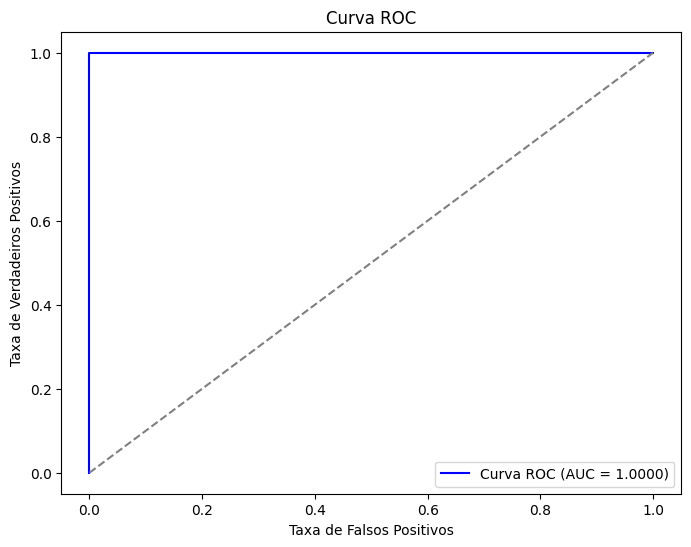

In [64]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Cálculo das métricas básicas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Exibir as métricas básicas
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
print(conf_matrix)

# Visualizar a Matriz de Confusão
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Não Oportunidade', 'Oportunidade'], yticklabels=['Não Oportunidade', 'Oportunidade'])
plt.title('Matriz de Confusão')
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.show()

# Curva ROC e AUC
# Calcular a AUC, se a variável target for binária
roc_auc = roc_auc_score(y_test, y_pred)
print(f"AUC: {roc_auc:.4f}")

# Para gerar a curva ROC
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Curva ROC')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.show()


In [ ]:
Com base nos resultados, dá pra tirar algumas ideias bem legais:

1. **Desempenho do Modelo**:
    - O modelo Random Forest mandou muito bem, com acurácia, precisão, recall e F1-Score todos em 1.0. Isso significa que ele acertou tudo no conjunto de teste.
    - A AUC (Área Sob a Curva ROC) também foi 1.0, mostrando que o modelo separa as classes perfeitamente.

2. **Importância das Features**:
    - As variáveis usadas no modelo, como `recent_reviews`, `all_reviews_count`, `recent_reviews_count` e `all_reviews`, foram ótimas pra identificar oportunidades de mercado.
    - Vale a pena dar uma olhada na importância de cada uma pra entender melhor o impacto delas.

3. **Oportunidades de Mercado**:
    - A variável `is_market_opportunity` foi criada com base em critérios simples: jogos com boas avaliações (`recent_reviews` acima da mediana) e baixa popularidade (`all_reviews_count` abaixo de 500). Isso ajudou a encontrar jogos com potencial de crescimento.

4. **Melhor Modelo e Parâmetros**:
    - O GridSearchCV encontrou os melhores parâmetros pro Random Forest, como `max_depth=10`, `min_samples_leaf=1`, `min_samples_split=2` e `n_estimators=100`. Esses ajustes foram essenciais pro ótimo desempenho.

5. **Visualização PCA**:
    - A análise PCA ajudou a reduzir a dimensionalidade e visualizar os jogos em 2D. Isso pode ser útil pra identificar padrões ou clusters nos dados.

6. **Matriz de Confusão**:
    - A matriz de confusão mostrou que o modelo não cometeu erros, sem falsos positivos ou negativos.

7. **Curva ROC**:
    - A curva ROC confirmou a separação perfeita entre as classes, alinhada com as métricas.

### Recomendações:
- **Testar Mais**: Mesmo com resultados perfeitos, é bom validar o modelo com outros dados pra garantir que ele não está superajustado.
- **Analisar Features**: Explorar a importância das variáveis pra entender o que mais influencia a classificação.
- **Explorar Oportunidades**: Usar os resultados pra investigar os jogos classificados como oportunidades e ver se eles realmente têm potencial.
- **Melhorar o Dataset**: Adicionar mais informações, como dados de vendas ou avaliações detalhadas, pra enriquecer a análise.

Essas ideias podem ajudar a tomar decisões estratégicas no mercado de jogos de forma mais embasada.